# Overview

# Busines Problem

# Data Understanding

# Data Preparation

In [175]:
#importing relevant libraries

import os
import pandas as pd 
import numpy as np

In [176]:
#Turn data folder into list of data file names

data_path = os.path.join('data','zippedData')
data_files = os.listdir(data_path)
data_files.pop(data_files.index('.ipynb_checkpoints'))
data_files.pop(data_files.index('Untitled.ipynb'))
data_files = [os.path.join(data_path,file) for file in data_files]
data_files

['data/zippedData/imdb.title.crew.csv.gz',
 'data/zippedData/tmdb.movies.csv.gz',
 'data/zippedData/imdb.title.akas.csv.gz',
 'data/zippedData/imdb.title.ratings.csv.gz',
 'data/zippedData/imdb.name.basics.csv.gz',
 'data/zippedData/rt.reviews.tsv.gz',
 'data/zippedData/imdb.title.basics.csv.gz',
 'data/zippedData/rt.movie_info.tsv.gz',
 'data/zippedData/tn.movie_budgets.csv.gz',
 'data/zippedData/bom.movie_gross.csv.gz',
 'data/zippedData/imdb.title.principals.csv.gz']

In [177]:
#Turn all data files into pandas dataframes 


data = {}
name_dict={'imdb.title.crew.csv.gz':"crew",
           'tmdb.movies.csv.gz':"movies",
           'imdb.title.akas.csv.gz':"akas",
           'imdb.title.ratings.csv.gz':"ratings",
           'imdb.name.basics.csv.gz':"name_basics",
           'rt.reviews.tsv.gz':"reviews",
           'imdb.title.basics.csv.gz':"title_basics",
           'rt.movie_info.tsv.gz':"movie_info",
           'tn.movie_budgets.csv.gz':"movie_budgets",
           'bom.movie_gross.csv.gz':"movie_gross",
           'imdb.title.principals.csv.gz':"principals"
          }
for file in data_files:
    try:
        df = pd.read_csv(file)
    except:
        print(file)
        continue
    file_name = file.split('/')[-1]
    data[name_dict[file_name]] = df
    
data["movie_info"]=pd.read_csv('data/zippedData/rt.movie_info.tsv.gz', sep="\t")
data["reviews"]=pd.read_csv('data/zippedData/rt.reviews.tsv.gz', sep="\t", encoding="latin1")

data/zippedData/rt.reviews.tsv.gz
data/zippedData/rt.movie_info.tsv.gz


## Cleaning

In [178]:
#Renaming columns to be able to merge on 'title' and 'tconst' columns

data['title_basics'].rename(columns={'primary_title':'title'}, inplace = True)
data['movie_budgets'].rename(columns={'movie':'title'}, inplace = True)
data['akas'].rename(columns={'title_id': 'tconst'}, inplace = True)

In [179]:
#Getting rid of commas and dollar signs to make dataframe values easier to work with 

data['movie_budgets']['worldwide_gross'] = data['movie_budgets']['worldwide_gross'].str.replace(',', '')
data['movie_budgets']['worldwide_gross'] = data['movie_budgets']['worldwide_gross'].str.replace('$', '')
data['movie_budgets']['worldwide_gross'] = data['movie_budgets']['worldwide_gross'].astype(int)

data['movie_budgets']['production_budget'] = data['movie_budgets']['production_budget'].str.replace(',', '')
data['movie_budgets']['production_budget'] = data['movie_budgets']['production_budget'].str.replace('$', '')
data['movie_budgets']['production_budget'] = data['movie_budgets']['production_budget'].astype(int)

In [180]:
#Filter ratings dataframe to a minimum of 100 votes

data['ratings'] = data['ratings'][data['ratings'].numvotes >= 100]

In [181]:
#Merging data on tconst

tconst_to_title = pd.merge(data['akas'],data['ratings'],on='tconst')

In [182]:
tconst_to_title.head(1)

,tconst,ordering,title,region,language,types,attributes,is_original_title,averagerating,numvotes
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.0,7.0,539338


In [183]:
#Dropping uncessary columns from tconst_to_title dataframe

tconst_to_title = tconst_to_title.drop(columns=['ordering','region','language','types','attributes','is_original_title'])
data['movie_budgets'] = data['movie_budgets'].drop(columns=['release_date','domestic_gross'])

In [184]:
tconst_to_title.head(1)

,tconst,title,averagerating,numvotes
0,tt0369610,Джурасик свят,7.0,539338


In [185]:
#Merging tconst_to_title dataframe with movie_budgets dataframe on 'title' column

master_table = pd.merge(tconst_to_title,data['movie_budgets'],on='title')

In [186]:
master_table.head(1)

,tconst,title,averagerating,numvotes,id,production_budget,worldwide_gross
0,tt0369610,Jurassic World,7.0,539338,34,215000000,1648854864


In [187]:
#Defining 'Composite Quality Score', Net Profit and ROI to help define successful movies

master_table['success_score'] = master_table.averagerating * (master_table.worldwide_gross / master_table.production_budget)
master_table["roi"]=master_table.worldwide_gross/master_table.production_budget
master_table["net_profit"]=master_table.worldwide_gross-master_table.production_budget

In [188]:
#Dropping duplicates from 'tconst' column in master_table dataframe

master_table.drop_duplicates(subset = ['tconst'],inplace=True)

In [189]:
#Merging title_basics dataframe to master_table dataframe on tconst

master_table = pd.merge(data['title_basics'],master_table,on='tconst')

In [190]:
#Merging movie_info dataframe to master_table dataframe

master_table = pd.merge(master_table, data['movie_info'],on='id')

In [191]:
master_table.head(1)

,tconst,title_x,original_title,start_year,runtime_minutes,genres,title_y,averagerating,numvotes,id,...,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",Saving Grace,8.1,263,95,...,R,Drama|Sports and Fitness,Ben Younger,Ben Younger,"Nov 18, 2016","Feb 14, 2017",$,"5,051,927",116 minutes,Open Road Films


In [192]:
#Drop remaining unnecessary columns

master_table.drop(columns=['original_title','title_y','theater_date','dvd_date','currency','box_office','studio','synopsis','runtime','writer'], inplace=True)

In [193]:
master_table.head(1)

,tconst,title_x,start_year,runtime_minutes,genres,averagerating,numvotes,id,production_budget,worldwide_gross,success_score,roi,net_profit,rating,genre,director
0,tt0137204,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",8.1,263,95,4000000,27786849,56.268369,6.946712,23786849,R,Drama|Sports and Fitness,Ben Younger


In [194]:
master_table.sort_values(by='worldwide_gross', ascending = False, inplace=True)

In [195]:
master_table = master_table.dropna(subset = ['director'])

In [197]:
#Creating df_composer dataframe for analyzing composer against success indicators

df_composer = data['name_basics'].dropna(subset=['primary_profession','known_for_titles'])
df_composer["title_length"]=df_composer["known_for_titles"].map(lambda x: x.count(',') + 1)
df_composer = df_composer[df_composer.primary_profession.str.contains('composer')]

/Users/MichaelWirtz/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [198]:
#sorting for most popular composers

df_composer.sort_values(by='title_length',ascending=False, inplace=True)

In [208]:
#Making composer dataframe by making tconst individualized *****WHAT HAPPENED? 

tconsts=list(df_composer["known_for_titles"][:32])
tconst_list=[]
for tconst in tconsts:
    tconst_list.append(list(tconst.split(",")))
tconst_list
tconst_master=[]
for tconst in tconst_list:
    for subtconst in tconst:
        tconst_master.append(subtconst)
        
unique_tconst_master=set(tconst_master)
vector=list(range(0,46984))
df_tconst=[]
df_consts=[]

for tconst in unique_tconst_master:
    for number in vector:
        if tconst in df_composer.iloc[number, 5]:
            df_tconst.append(tconst)
            df_consts.append(df_composer.iloc[number, 1])
            
tconst_table=pd.DataFrame({'composer':df_consts, 'tconst':df_genres})

tconst_table

,composer,tconst
0,Todd Maki,tt2233170
1,John Zuker,tt0106140
2,Lucas Maldonado,tt2338390
3,Rolando Marchesini,tt3470184
4,Mauro Magnani,tt3470184
...,...,...
199,Samuel Ferrari,tt1567609
200,Pablo Lescano,tt1567609
201,Yamil Rezc,tt1567609
202,Jeff Caughey,tt1567609


In [200]:
#Merging master with composer table

master_composer = pd.merge(master_table,tconst_table, on='tconst')



In [204]:
#Removing deceased composers and problem data

master_composer = master_composer[master_composer.composer != 'Matthew Emerson Brown']
master_composer = master_composer[master_composer.composer != 'Joshua Morrison']
master_composer = master_composer[master_composer.composer != 'Jeramy Koepping']
master_composer = master_composer[master_composer.composer != 'Ed Cortes']
master_table = master_table[master_table.director != 'Rodney Bennett']
master_table = master_table[master_table.director != 'Rick Rosenthal']

In [205]:
master_composer.sort_values(by='success_score', ascending = False, inplace = True)

## Merging

## Feature Engineering

# Analysis

In [170]:
#Importing relevant libraries

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

 ### What Effect Does Director Have on a Movie's Success?

All movies from the data set were decomposed into their corresponding directors. Each like director was then grouped across all movies in the data set and measured against the four established success indicators (shown in graphs below).

For the revenue and net profit indicators, director John Woo is the leader followed closely by director Matt Bettinelli-Olpin. For the ROI and success score indicators, Jim Jarmusch is the overwhelming leading scorer with a median ROI of almost 12 and a success score of over 75. 

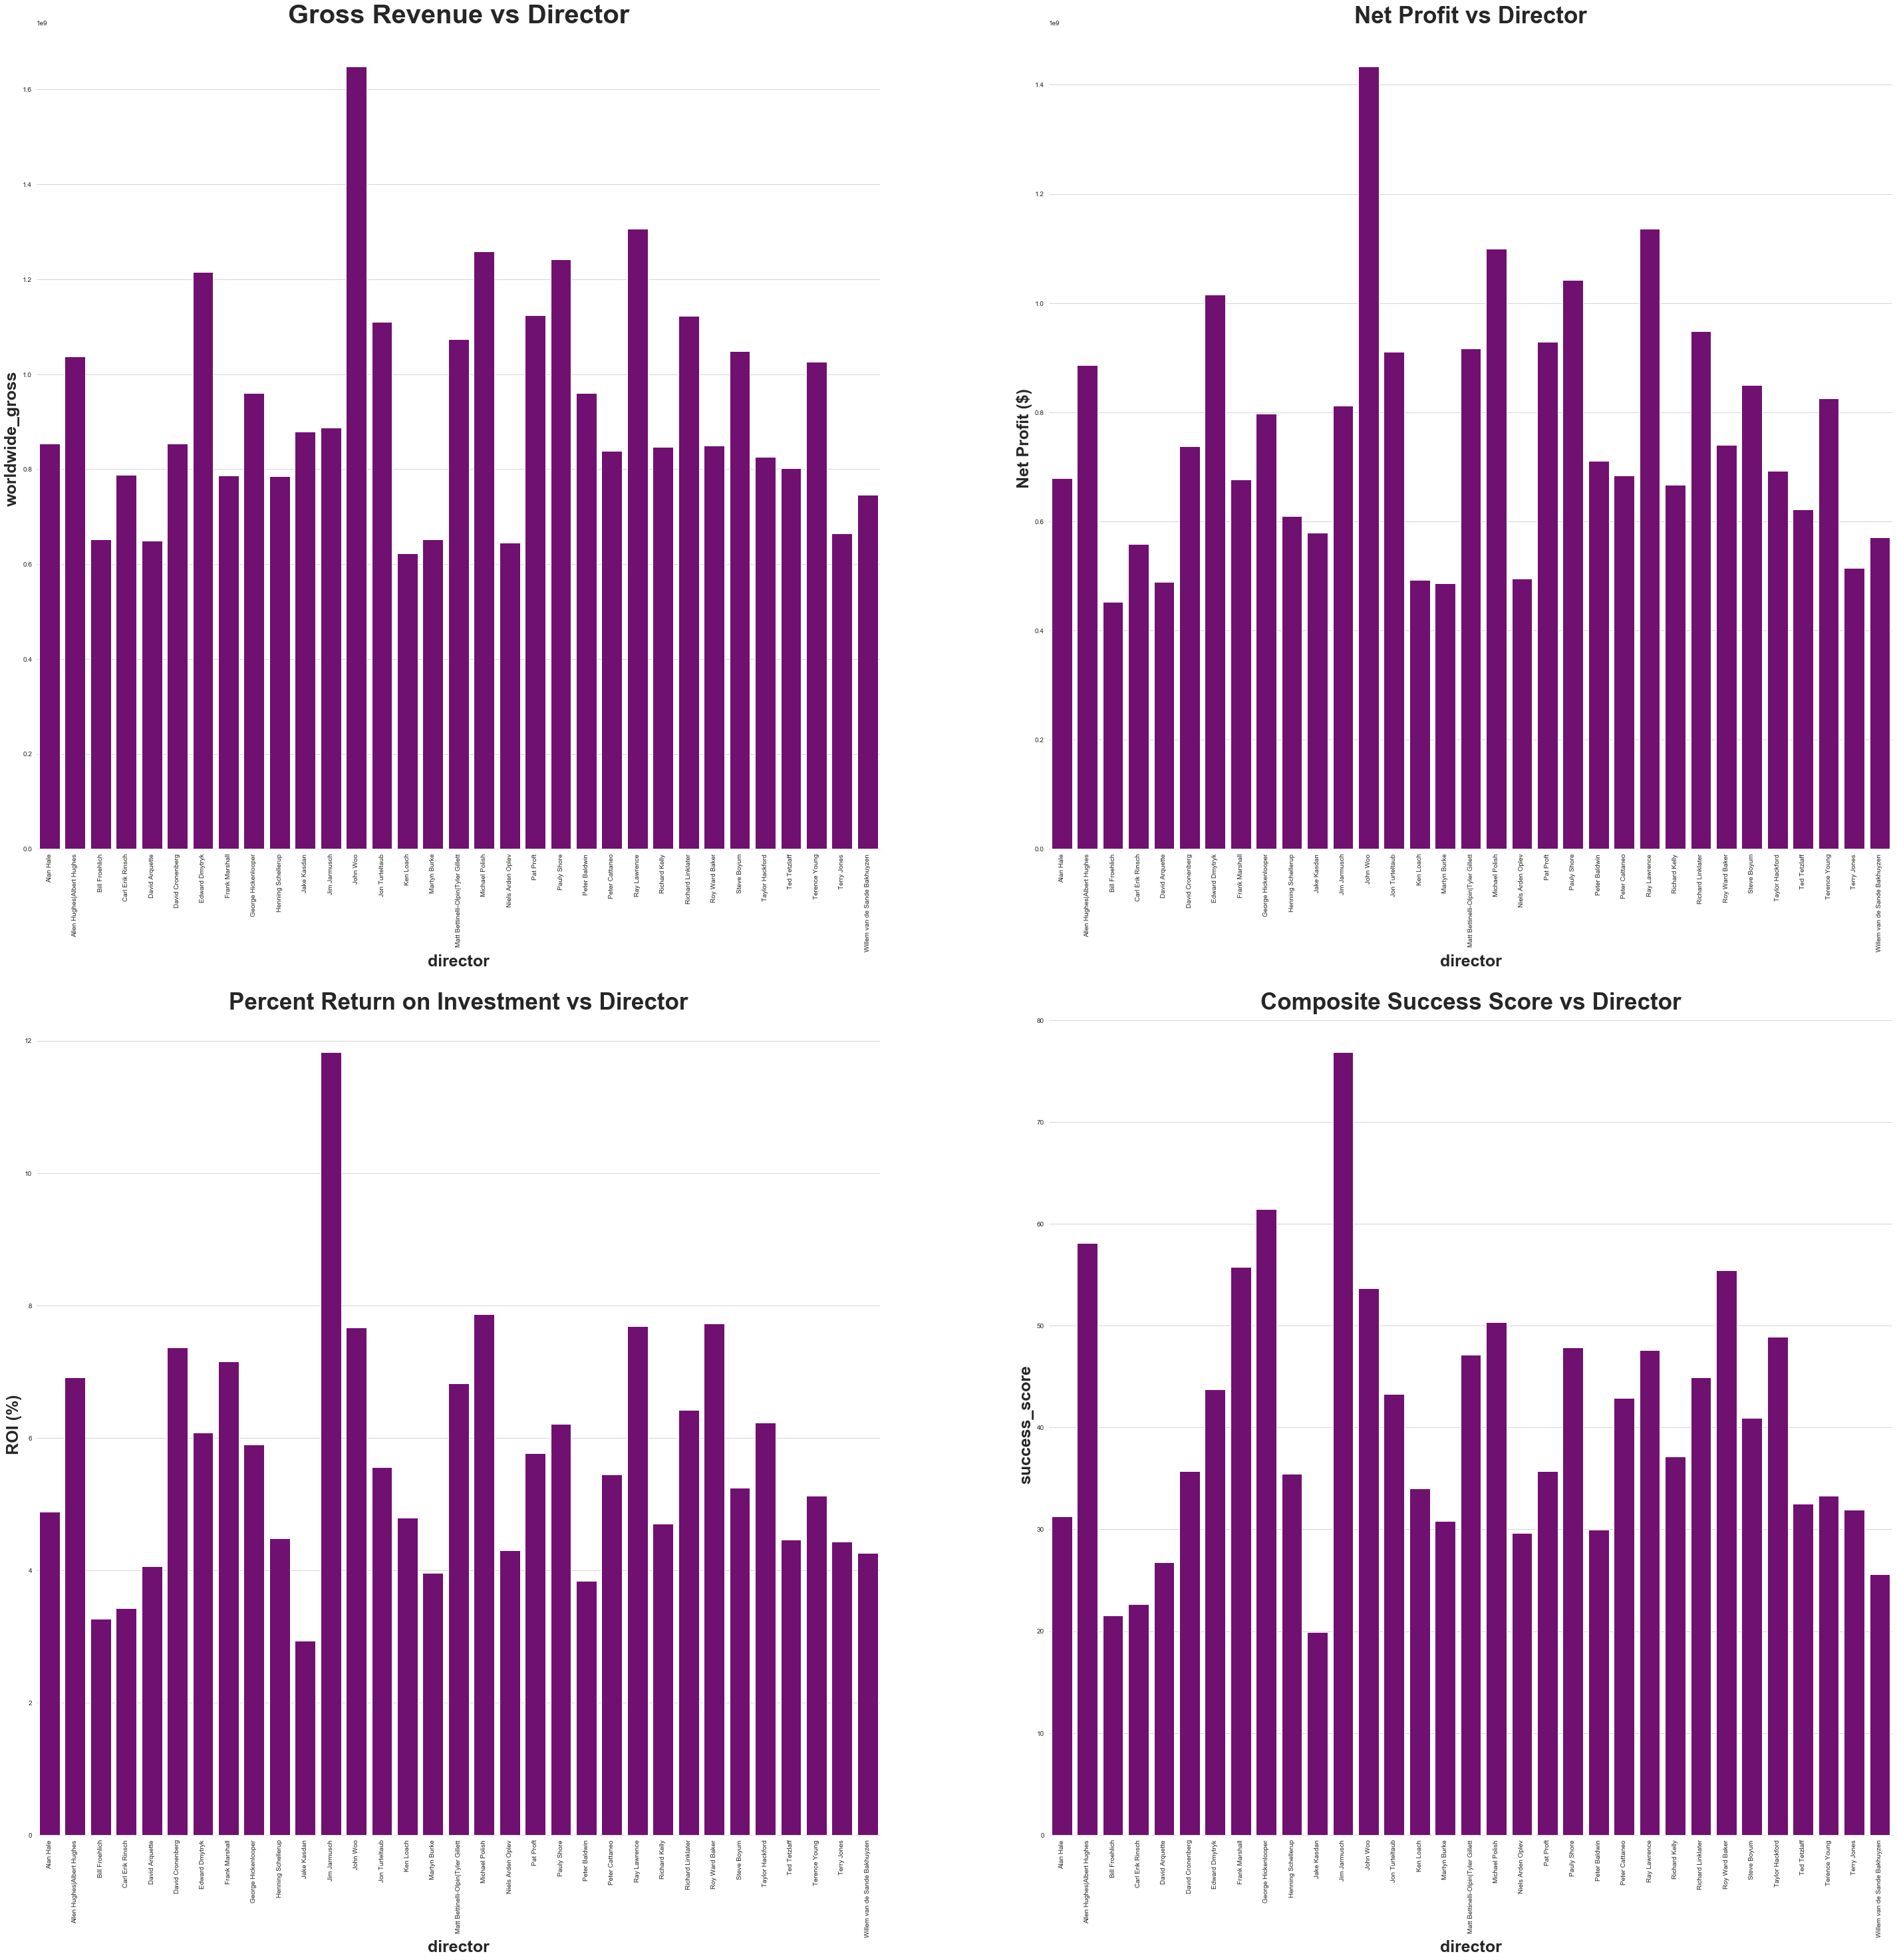

In [206]:
#Graphing Director vs Gross Revenue, Net Profit, ROI, and Success Score

figure, ax = plt.subplots(2, 2, figsize=(50, 50))
x=master_table[:50].groupby("director").median().index

y0_gross_rev= master_table[:50].groupby("director").median().worldwide_gross
y1_net_prof= master_table[:50].groupby("director").median().worldwide_gross-master_table[:50].groupby("director").median().production_budget
y2_roi_percent= master_table[:50].groupby("director").median().worldwide_gross/master_table[:50].groupby("director").median().production_budget
y3_comp= master_table[:50].groupby("director").median().success_score 

ax[0][0].set_title('Gross Revenue vs Director', fontsize = 40, fontweight="bold")
ax[0][0].set_xlabel('Director', fontsize = 25, fontweight="bold")
ax[0][0].set_ylabel('Gross Revenue ($)', fontsize = 25, fontweight="bold")
ax[0][1].set_title('Net Profit vs Director', fontsize = 35, fontweight="bold")
ax[0][1].set_xlabel('Director', fontsize = 25, fontweight="bold")
ax[0][1].set_ylabel('Net Profit ($)', fontsize = 25, fontweight="bold")
ax[1][0].set_title('Percent Return on Investment vs Director', fontsize = 35, fontweight="bold")
ax[1][0].set_xlabel('Director', fontsize = 25, fontweight="bold")
ax[1][0].set_ylabel('ROI (%)', fontsize = 25, fontweight="bold")
ax[1][1].set_title('Composite Success Score vs Director', fontsize = 35, fontweight="bold")
ax[1][1].set_xlabel('Director', fontsize = 25, fontweight="bold")
ax[1][1].set_ylabel('Success Score', fontsize = 25, fontweight="bold")

ax[0][0].set_xticklabels(x,rotation=90)
ax[0][1].set_xticklabels(x,rotation=90)
ax[1][0].set_xticklabels(x,rotation=90)
ax[1][1].set_xticklabels(x,rotation=90)

ax[0][0].spines['top'].set_visible(False)
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['left'].set_visible(False)
ax[0][0].spines['bottom'].set_color('#DDDDDD')

ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['left'].set_visible(False)
ax[0][1].spines['bottom'].set_color('#DDDDDD')

ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['left'].set_visible(False)
ax[1][0].spines['bottom'].set_color('#DDDDDD')

ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['left'].set_visible(False)
ax[1][1].spines['bottom'].set_color('#DDDDDD')

sns.set_style("whitegrid")
sns.barplot(x, y0_gross_rev, ax=ax[0][0], color='purple')
sns.barplot(x, y1_net_prof, ax=ax[0][1], color='purple')
sns.barplot(x, y2_roi_percent, ax=ax[1][0], color='purple')
sns.barplot(x, y3_comp, ax=ax[1][1], color='purple')


### What Effect Does the Composer Have on a Movie's Success?

All movies from the data set were decomposed into their corresponding composers. Each like composer was then grouped across all movies in the data set and measured against the four established success indicators (shown in graphs below).

The 7 composers featured are those 7 linked to the highest grossing movies of the whole composer dataframe. While there is much variation amongst the four indicator graphs, Ed Côrtes stands out among the 7 composers as the most cross-categorically linked to successful movies as defined by the four indicators. 

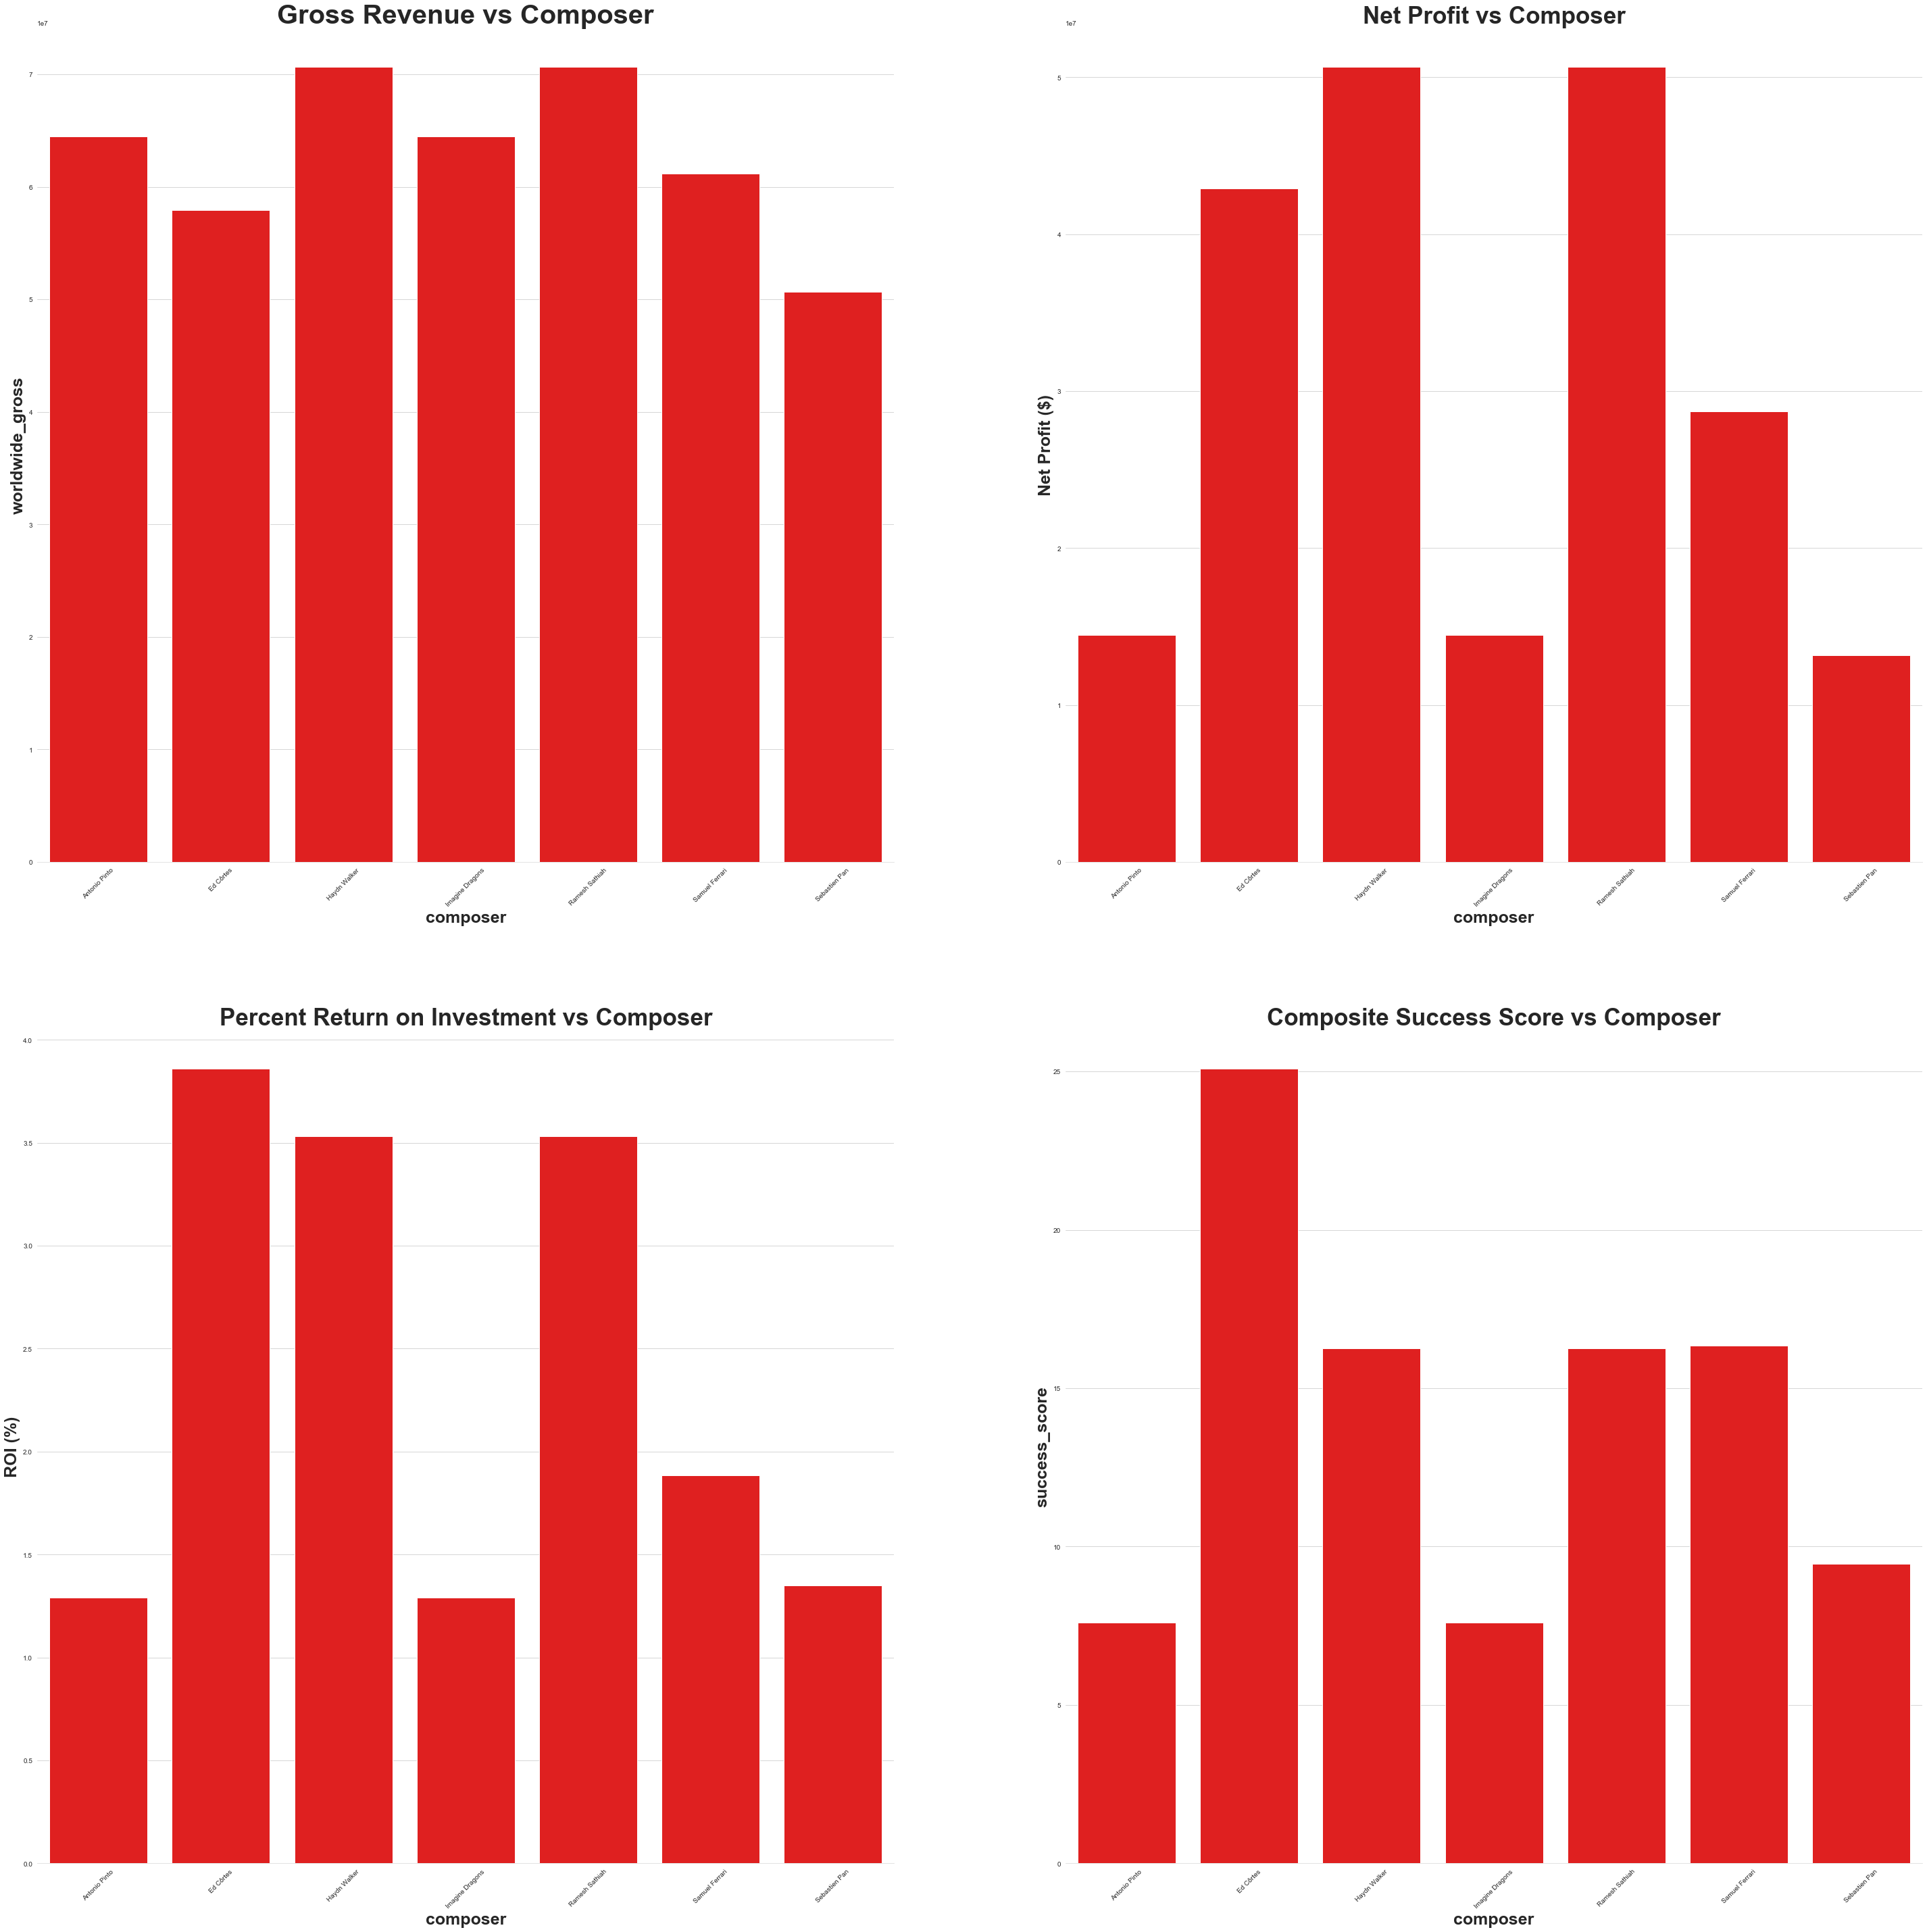

In [172]:
#Graphing Composer vs Gross Revenue, Net Profit, ROI, and Success Score

figure, ax = plt.subplots(2, 2, figsize=(50, 50))
x=master_composer.groupby("composer").median().index
y0_gross_rev= master_composer.groupby("composer").median().worldwide_gross
y1_net_prof= master_composer.groupby("composer").median().worldwide_gross-master_composer.groupby("composer").median().production_budget
y2_roi_percent= master_composer.groupby("composer").median().worldwide_gross/master_composer.groupby("composer").median().production_budget
y3_comp= master_composer.groupby("composer").median().success_score 

ax[0][0].set_title('Gross Revenue vs Composer', fontsize = 40, fontweight="bold")
ax[0][0].set_xlabel('Composer', fontsize = 25, fontweight="bold")
ax[0][0].set_ylabel('Gross Revenue ($)', fontsize = 25, fontweight="bold")
ax[0][1].set_title('Net Profit vs Composer', fontsize = 35, fontweight="bold")
ax[0][1].set_xlabel('Composer', fontsize = 25, fontweight="bold")
ax[0][1].set_ylabel('Net Profit ($)', fontsize = 25, fontweight="bold")
ax[1][0].set_title('Percent Return on Investment vs Composer', fontsize = 35, fontweight="bold")
ax[1][0].set_xlabel('Composer', fontsize = 25, fontweight="bold")
ax[1][0].set_ylabel('ROI (%)', fontsize = 25, fontweight="bold")
ax[1][1].set_title('Composite Success Score vs Composer', fontsize = 35, fontweight="bold")
ax[1][1].set_xlabel('Year', fontsize = 25, fontweight="bold")
ax[1][1].set_ylabel('Success Score', fontsize = 25, fontweight="bold")

ax[0][0].set_xticklabels(x,rotation=45)
ax[0][1].set_xticklabels(x,rotation=45)
ax[1][0].set_xticklabels(x,rotation=45)
ax[1][1].set_xticklabels(x,rotation=45)

ax[0][0].spines['top'].set_visible(False)
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['left'].set_visible(False)
ax[0][0].spines['bottom'].set_color('#DDDDDD')

ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['left'].set_visible(False)
ax[0][1].spines['bottom'].set_color('#DDDDDD')

ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['left'].set_visible(False)
ax[1][0].spines['bottom'].set_color('#DDDDDD')

ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['left'].set_visible(False)
ax[1][1].spines['bottom'].set_color('#DDDDDD')

sns.set_style("whitegrid")
sns.barplot(x, y0_gross_rev, ax=ax[0][0], color='red')
sns.barplot(x, y1_net_prof, ax=ax[0][1], color='red')
sns.barplot(x, y2_roi_percent, ax=ax[1][0], color='red')
sns.barplot(x, y3_comp, ax=ax[1][1], color='red')

### What Trends Can We See Between Year and Movie Success?

All movies from the data set were decomposed into their corresponding release years. Each like year was then grouped across all movies in the data set and measured against the four established success indicators (shown in graphs below). 

For all four indicators, you can see that there is a steep decline in scores across the board for the year 2019 after a general upward trend. Since movie indicator scores over the last 9 years have been quite volatile, there may be nothing to worry about regarding the downward turn. It may also be a good time to get into the business at a discount or partner with a small struggling studio. A possible concern is the sudden drop in ROI after years of maintaining steady percentages. 

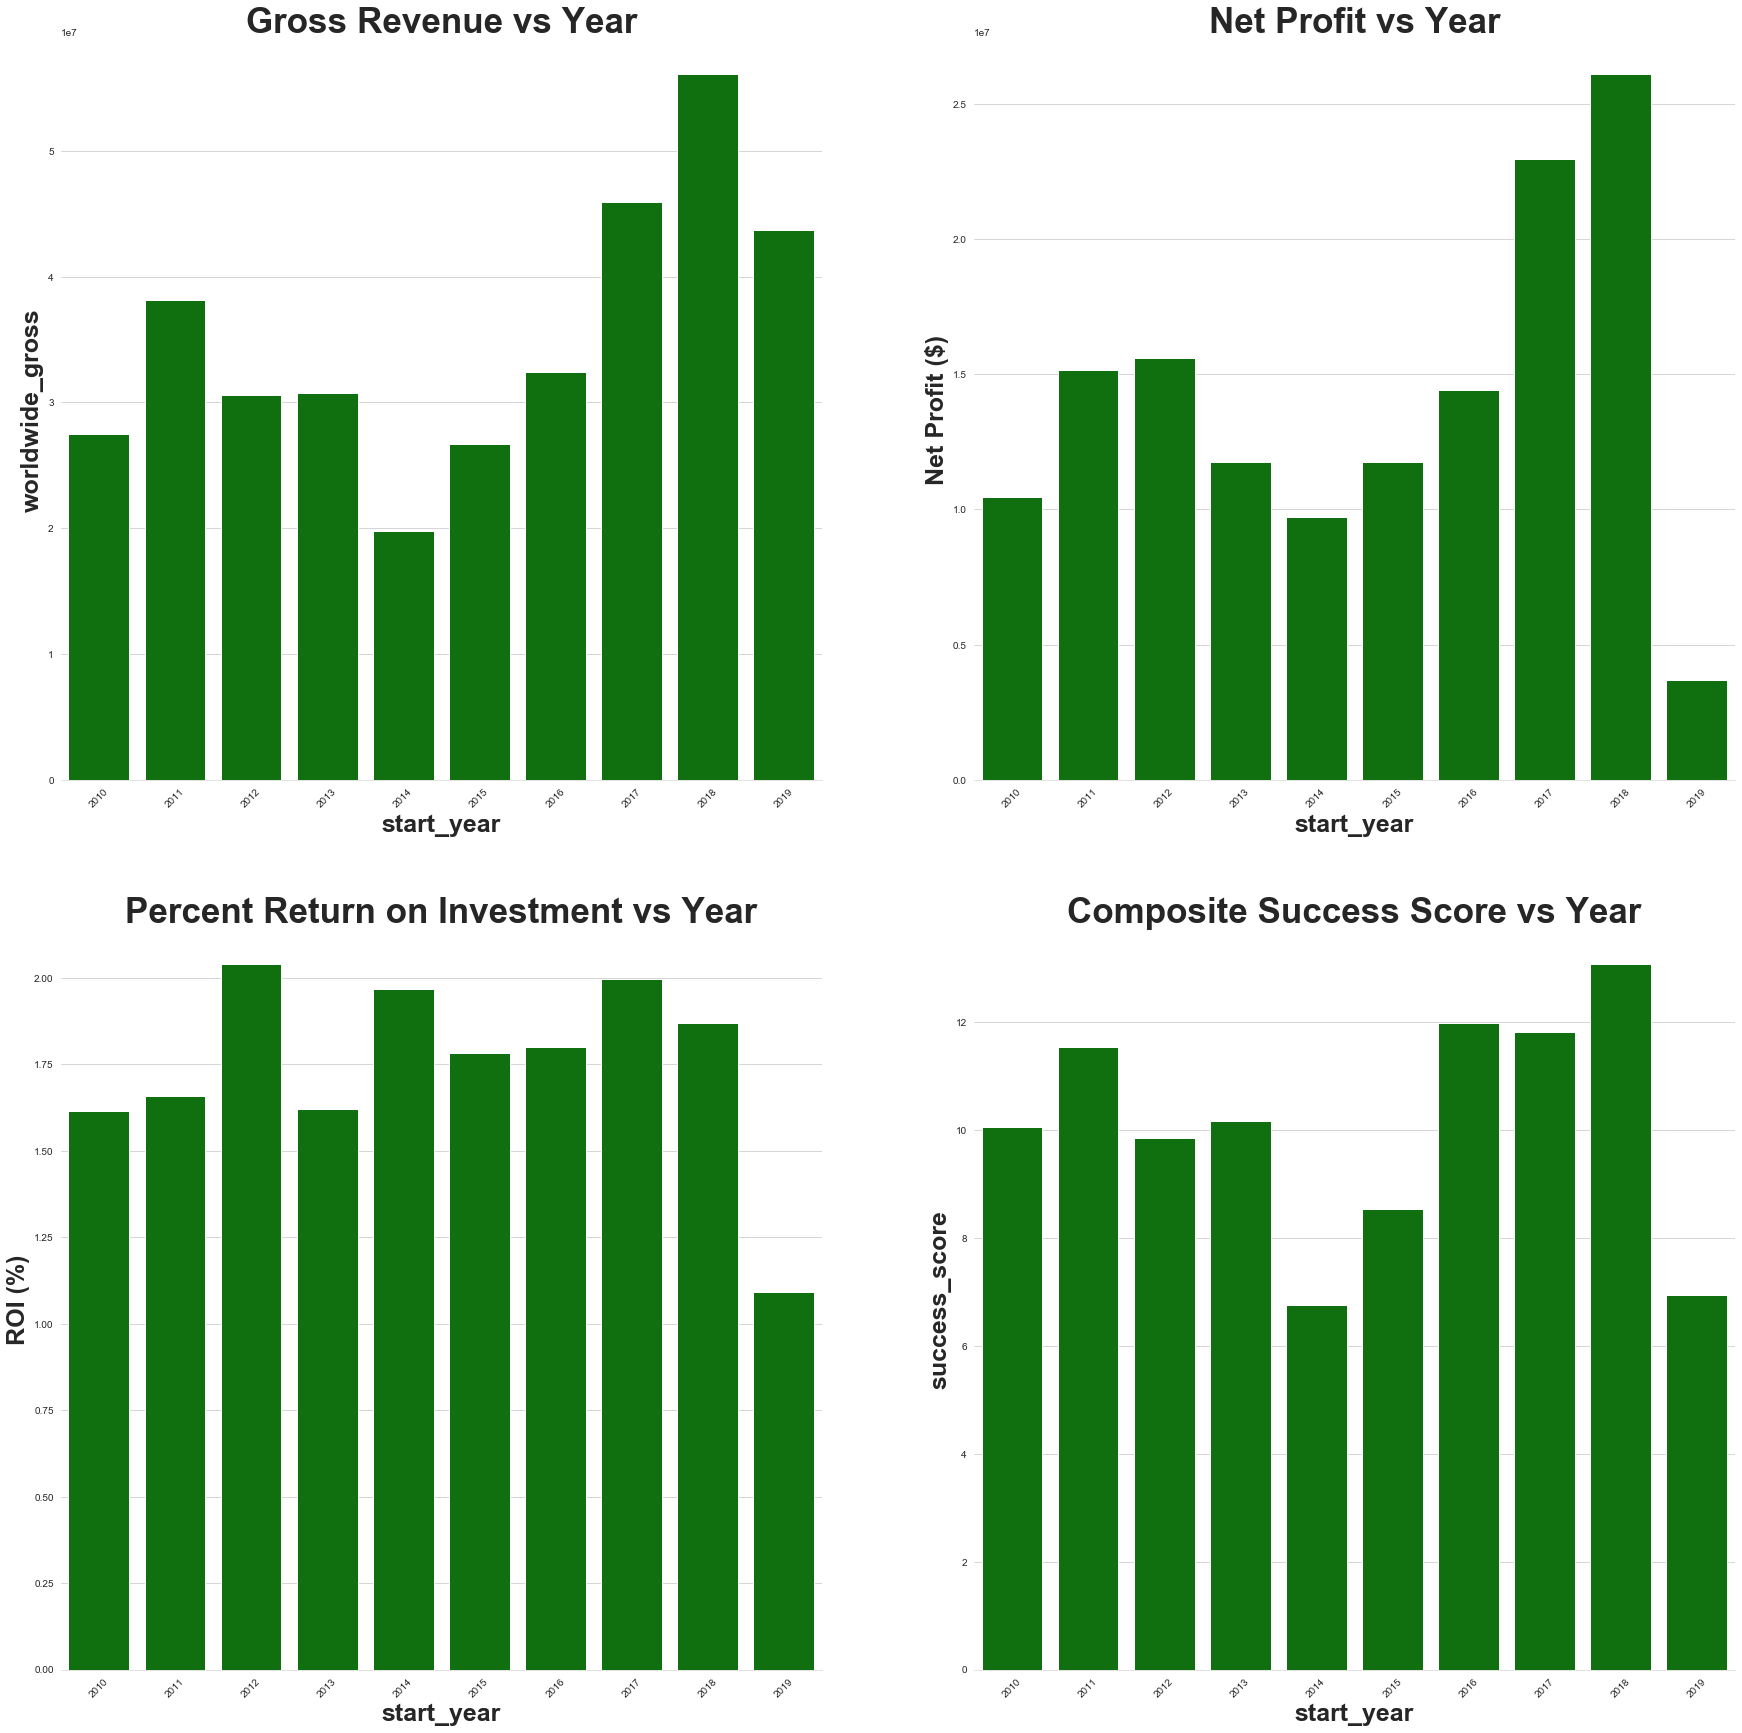

In [173]:
#Graphing Start Year vs Gross Revenue, Net Profit, ROI, and Success Score

figure, ax = plt.subplots(2, 2, figsize=(30, 30))
x=master_table.groupby("start_year").median().index
y0_gross_rev= master_table.groupby("start_year").median().worldwide_gross
y1_net_prof= master_table.groupby("start_year").median().worldwide_gross-master_table.groupby("start_year").median().production_budget
y2_roi_percent= master_table.groupby("start_year").median().worldwide_gross/master_table.groupby("start_year").median().production_budget
y3_comp= master_table.groupby("start_year").median().success_score 

ax[0][0].set_title('Gross Revenue vs Year', fontsize = 35, fontweight="bold")
ax[0][0].set_xlabel('Year', fontsize = 25, fontweight="bold")
ax[0][0].set_ylabel('Gross Revenue ($)', fontsize = 25, fontweight="bold")
ax[0][1].set_title('Net Profit vs Year', fontsize = 35, fontweight="bold")
ax[0][1].set_xlabel('Year', fontsize = 25, fontweight="bold")
ax[0][1].set_ylabel('Net Profit ($)', fontsize = 25, fontweight="bold")
ax[1][0].set_title('Percent Return on Investment vs Year', fontsize = 35, fontweight="bold")
ax[1][0].set_xlabel('Year', fontsize = 25, fontweight="bold")
ax[1][0].set_ylabel('ROI (%)', fontsize = 25, fontweight="bold")
ax[1][1].set_title('Composite Success Score vs Year', fontsize = 35, fontweight="bold")
ax[1][1].set_xlabel('Year', fontsize = 25, fontweight="bold")
ax[1][1].set_ylabel('Success Score', fontsize = 25, fontweight="bold")

ax[0][0].set_xticklabels(x,rotation=45)
ax[0][1].set_xticklabels(x,rotation=45)
ax[1][0].set_xticklabels(x,rotation=45)
ax[1][1].set_xticklabels(x,rotation=45)

ax[0][0].spines['top'].set_visible(False)
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['left'].set_visible(False)
ax[0][0].spines['bottom'].set_color('#DDDDDD')

ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['left'].set_visible(False)
ax[0][1].spines['bottom'].set_color('#DDDDDD')

ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['left'].set_visible(False)
ax[1][0].spines['bottom'].set_color('#DDDDDD')

ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['left'].set_visible(False)
ax[1][1].spines['bottom'].set_color('#DDDDDD')

sns.set_style("whitegrid")
sns.barplot(x, y0_gross_rev, ax=ax[0][0], color='green')
sns.barplot(x, y1_net_prof, ax=ax[0][1], color='green')
sns.barplot(x, y2_roi_percent, ax=ax[1][0], color='green')
sns.barplot(x, y3_comp, ax=ax[1][1], color='green')

# Conclusions

## Next Steps

Further analysis into each of the factors tested above may produce more accurate and/or specific and actionable insights. Moving into the future, we could look at the following: 

 - Model the salary of directors vs median movie ROI for that director
 - Model composers' genre variations to find most versatile composer
 - Model line of best fit for year to find a usable trendline